In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import norm
import scipy
import scipy.stats
from scipy.optimize import curve_fit
from pylab import exp
from scipy import optimize
from math import sqrt
import glob
import h5py   
from matplotlib.colors import LogNorm, Normalize
from scipy.interpolate import interp1d

In [2]:
def deltat(time,ch1,ch2):
    half1= max(ch1)/2
    half2= max(ch2)/2
    i=0
    while ch1[i]<half1:
        i=i+1
    j=0
    while ch2[j]<half2:
        j=j+1
    t1= time[i]
    t2= time[j]
    dt= time[j]-time[i]
    return dt, t1 ,t2

def tot(time, ch):
    half= (max(ch)-min(ch))/2 + min(ch) #find half point of the rise
    i=0
    while ch[i]<half: #find the element which is higher then the halfpoint
        i=i+1
    x1= [time[i-1],time[i]]
    y1= [ch[i-1],ch[i]]
    xnew1= np.linspace(time[i-1],time[i],200)
    f1 = interp1d(x1, y1)#linearly interpolate of these two points
    ynew1= f1(xnew1)
    k=0
    while ynew1[k]<half:
        k=k+1#find the right point of the interpolation
    j=i+30 #no do the same for the falling edge
    while ch[j]>half:
        j=j+1
    
    x2= [time[j-1],time[j]]
    y2= [ch[j-1],ch[j]]
    xnew2= np.linspace(time[j-1],time[j],200)
    f2 = interp1d(x2, y2)
    ynew2= f2(xnew2)
    z=0
    while ynew2[z]<half:
        z=z+1
    tott= xnew2[z]- xnew1[k]#calculate the tot
    return tott

In [3]:
a=glob.glob("/data/detrd/ukraemer/osci_data/cal_scan_P0_59V_P16_6ms_W50us_B100V/*")

a= sorted(a)

len(a)

110004

In [4]:
pixelnames=[]
temp=[]
for i in range(len(a)):
    if i==0:
        temp.append(a[i])
    elif a[i]==a[-1]:
        temp.append(a[i])
        pixelnames.append(temp)
    elif a[i][76:82]==a[i-1][76:82]:
        temp.append(a[i])
    else:
        pixelnames.append(temp)
        temp=[]
        temp.append(a[i])

In [5]:
temp=[]
for i in range(3):
    f= h5py.File(a[i])
    temp.append(f)
time=np.array(temp[1]["Time"])

In [6]:
len(pixelnames)

64

In [7]:
%%time
pixelsdt=[]
pixelstot=[]


for i in range(len(pixelnames)):
    temp2=[]
    temp3=[]
    for j in range(len(pixelnames[i])):
        temp1=h5py.File(pixelnames[i][j])
        ch1= temp1["Voltage_CHAN1"]
        ch1= np.array(ch1)
        ch2= temp1["Voltage_CHAN2"]
        ch2= np.array(ch2)
        if max(ch2)<0.1:
            empty1.append(max(ch2))
        else:
            dt,t2,t3 =deltat(time,ch1,ch2)
            temp2.append(dt)
            temp3.append(tot(time,ch2))
        temp1.close()
    pixelsdt.append(temp2)
    pixelstot.append(temp3)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
CPU times: user 26min 41s, sys: 31.9 s, total: 27min 13s
Wall time: 34min 52s


In [8]:
datafile=[]

for i in range(len(pixelstot)):
    temp=[]
    for j in range(len(pixelstot[i])):
        temp.append(pixelstot[i][j])
    datafile.append(temp)
    
datafile= np.transpose(datafile)

np.savetxt("cal_scan_P0_59V_P16_6ms_W50us_B100V_tot",datafile, fmt='%s')

/opt/tljh/user/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [9]:
datafile1=[]

for i in range(len(pixelsdt)):
    temp=[]
    for j in range(len(pixelsdt[i])):
        temp.append(pixelsdt[i][j])
    datafile1.append(temp)
    
datafile1= np.transpose(datafile1)

np.savetxt("cal_scan_P0_59V_P16_6ms_W50us_B100V_deltat",datafile1, fmt='%s')



In [10]:
def Gaussian(x,a,b,c):
    return a * exp(-(x - b)**2.0 / (2 * c**2))

In [11]:
det=pixelsdt[11]

In [12]:
det0=[]
for i in range(len(det)):
    det0.append(det[i]-np.mean(det))

In [13]:
det0=np.asarray(det0)*10**9


 Curve-fit Curve fit: [3.39771036e+02 6.20054188e-04 1.16676298e-01]

 Curve-fit Fit errors: [4.43950158e+00 1.76031201e-03 1.76046450e-03]


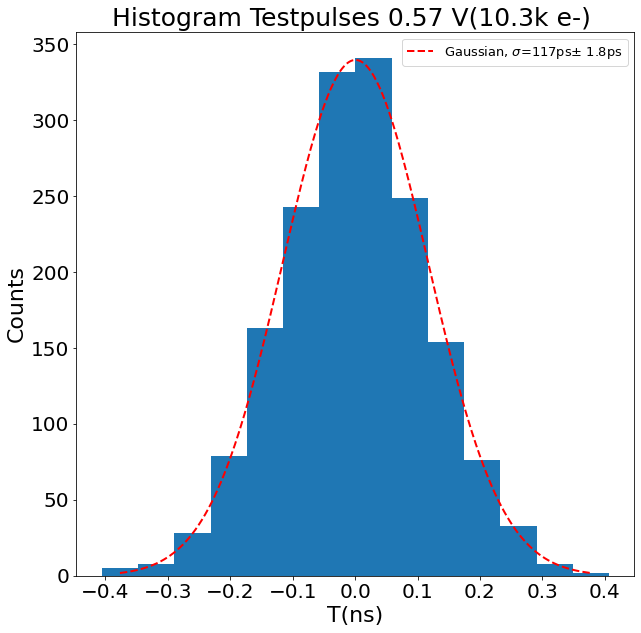

In [32]:
nbins=14
data = det0
fig = plt.figure(figsize=(10,10))

n,bins,patches = plt.hist(data,bins=nbins)

# Generate data from bins as a set of points 
bin_size = abs(bins[1]-bins[0])
x =np.linspace(start=bins[0]+bin_size/2.0,stop=bins[-2]+bin_size/2.0,\
num=nbins,endpoint=True)


y = n
y[y==0]= 1e-8


newy=[]
newx=[]
for i in range(len(y)):
    if y[i]>=1:
        newy.append(y[i])
        newx.append(x[i])


popt, pcov = optimize.curve_fit(Gaussian,newx,newy) 

# Curve-fit error method
error = [] 
for i in range(len(popt)):
    try:
      error.append( np.absolute(pcov[i][i])**0.5)
    except:
      error.append( 0.00 )
pfit_curvefit = popt
perr_curvefit = np.array(error) 
print('\n Curve-fit Curve fit: %s' % pfit_curvefit)
print('\n Curve-fit Fit errors: %s' % perr_curvefit)

# Plot the fit
x_fit = np.linspace(x[0], x[-1], 300)
y_gauss = Gaussian(x_fit, *popt)
yerr=Gaussian(x_fit,*perr_curvefit)

plt.plot(x_fit, y_gauss,linestyle='--',linewidth=2,\
color='red',label='Gaussian, $\sigma$=117ps$\pm$ 1.8ps ')
plt.title("Histogram Testpulses 0.57 V(10.3k e-) ",fontsize=25)
fig.patch.set_facecolor('xkcd:white')
plt.ylabel("Counts",fontsize=22)
plt.xlabel("T(ns)",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=13)


plt.savefig("histogram_testpulses.png", dpi=150)
plt.show()


In [19]:
np.std(det0)

0.127570994285758

In [16]:
popt, pcov = optimize.curve_fit(Gaussian,x,y) 

/user/dnobels/.local/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


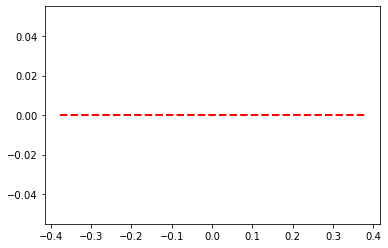

In [17]:
p0= [350,0,np.std(det)]
popt, pcov = optimize.curve_fit(Gaussian,x,y,p0) 
x_fit = np.linspace(x[0], x[-1], nbins)
y_gauss = Gaussian(x_fit, *popt)
yerr=Gaussian(x_fit,*perr_curvefit)

plt.plot(x_fit, y_gauss,linestyle='--',linewidth=2,\
color='red',label='Gaussian, $\sigma$=209ps $\pm$ 2.5ps ')

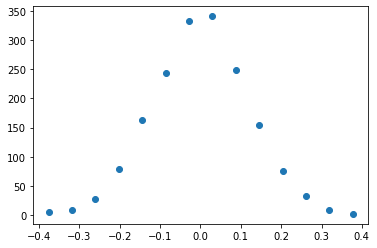

In [18]:
plt.scatter(x,y)